In [1]:
import os
import cartopy
import datetime
import shapely

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):

    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    lllon, lllat = imextent[0], imextent[1]
    urlon, urlat = imextent[2], imextent[3]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.GoogleTiles(style='terrain', url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 24)
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)
    cbar.ax.tick_params(labelsize=14) 
    
    return 



In [3]:
# Setup dirs
smlt_dir = "../results/BF_XC_final/merged/"
prcp_dir = "../results/BF_XC_final/merged/"

# Get lists of files 
smlt_files = os.path.abspath([os.path.join(smlt_dir,x) for x in os.listdir(smlt_dir) if x.endswith(".tiff") and "ann_smlt" in x][0])
prcp_files = os.path.abspath([os.path.join(prcp_dir,x) for x in os.listdir(prcp_dir) if x.endswith(".tiff") and "ann_prcp" in x][0])

FileNotFoundError: [Errno 2] No such file or directory: '../results/BF_XC_final/merged/'

In [4]:
# Calc the annual averages
# Calc the annual averages
def read_raster(fn, scale_factor=1):
    src = rio.open(fn)
    arr = src.read(1).astype(np.float64) 
    ndval = src.nodata
    arr[arr== ndval] = np.nan
    arr = arr/scale_factor
    return arr
        
ann_avg_smlt = read_raster(smlt_files, scale_factor = 1) 
ann_avg_prcp = read_raster(prcp_files, scale_factor = 1)

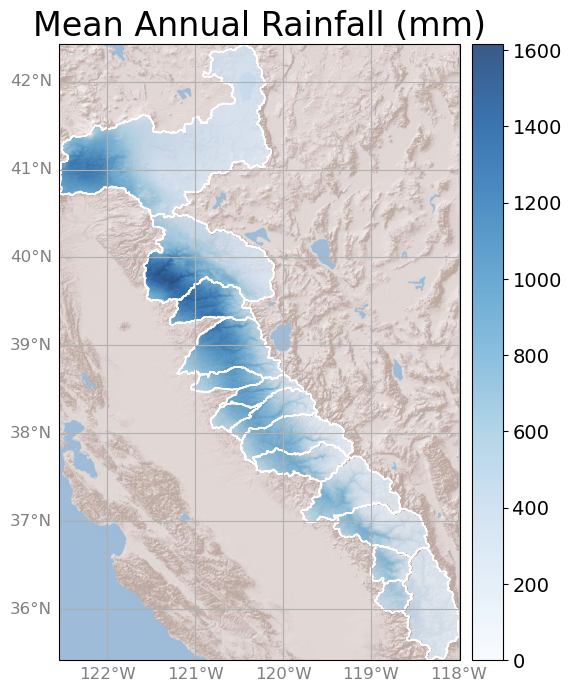

In [5]:
# Plot Precip
outlets = gp.read_file("../shape/term_res.shp")
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(np.where(ann_avg_prcp==0,np.nan,ann_avg_prcp), "../shape/sierra_catchments.shp", "Mean Annual Rainfall (mm)", cmap = 'Blues', ax = axes, latlabels = True, lonlabels = True )
# outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

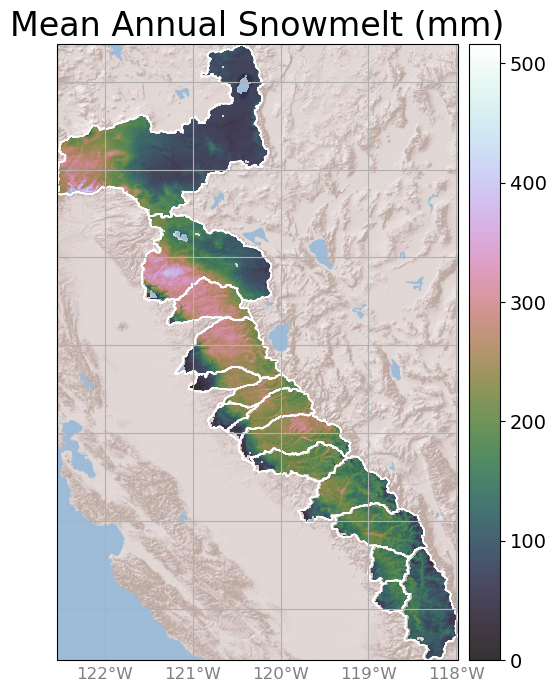

In [6]:
# Plot snowmelt
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(np.where(ann_avg_smlt==0,np.nan,ann_avg_smlt), "../shape/sierra_catchments.shp", "Mean Annual Snowmelt (mm)", cmap = 'cubehelix', ax = axes, latlabels = False, lonlabels = True)
# outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_28165/4057691048.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axes.text(row.coords[0], row.coords[1], s=row['catch_name'][:3], horizontalalignment='center', size = 12,


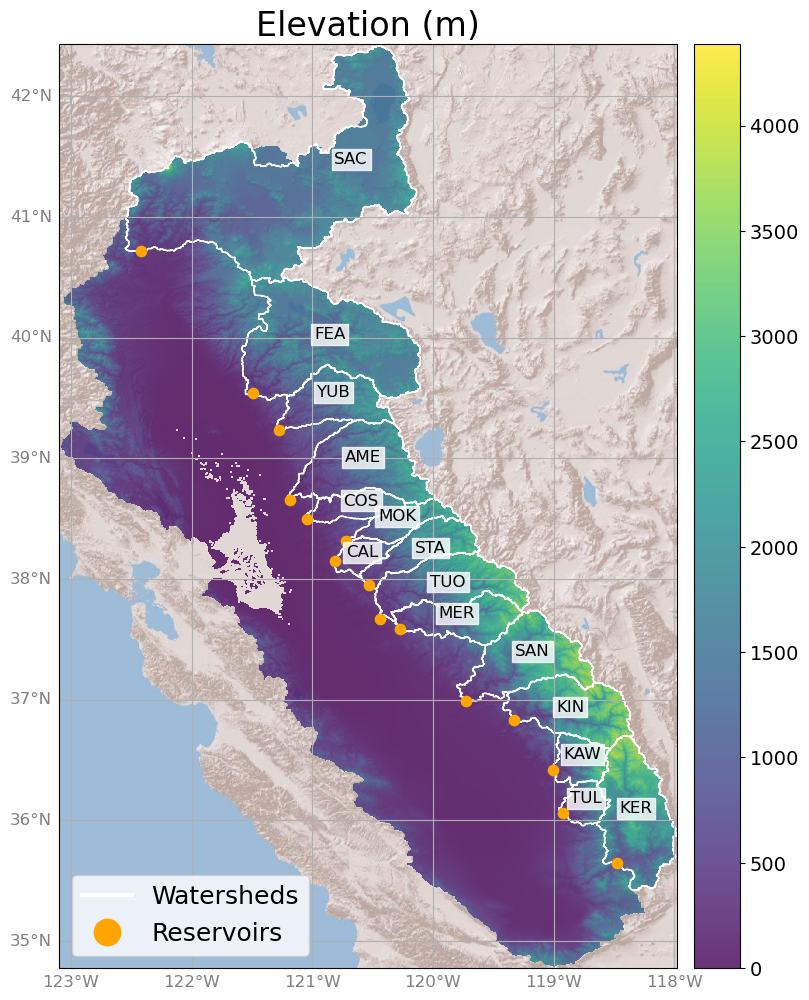

In [8]:
# Read elevation
esrc = rio.open("../data/SRTM/dem_masked.tif")
earr = esrc.read(1).astype(float)
earr[earr==0] = np.nan

# Plot Elevation
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})
ax1 = plot_basemaps(earr, "../shape/cvws.shp", "Elevation (m)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True )
outlets.plot(ax = axes, color = 'orange', markersize = 55, edgecolor = 'orange', zorder = 4)

# Get some coords for shed labels
catchments = gp.read_file("../shape/sierra_catchments.shp")

c = catchments.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    axes.text(row.coords[0], row.coords[1], s=row['catch_name'][:3], horizontalalignment='center', size = 12,
    bbox={'facecolor': 'none', 'alpha':0.8, 'pad': 2, 'edgecolor':'none', 'color' : 'white'}, zorder= 5)

    
shed_patch = Line2D([0],[0],color='white',label='Watersheds', lw=3)
res_patch = Line2D([0],[0],marker='o',markersize=19,color='orange', markeredgecolor = 'orange',label='Reservoirs', lw=0)

plt.legend(handles=[shed_patch, res_patch], loc = 'lower left', fontsize = 18)
plt.show()

In [9]:
# Make a box around the sierras 
lat_lons = [[-119.545703125, 35.109751975229344],
          [-116.6453125, 35.89679176687373],
          [-120.600390625, 43.14003464053211],
          [-123.412890625, 42.56011954602293]]

gmtry = shapely.geometry.Polygon([shapely.geometry.Point(x[0],x[1]) for x in lat_lons])

/var/folders/zd/rjxfh38941s3dn35jv9cdgmw0000gn/T/ipykernel_28165/3327201942.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  imextent = gp.read_file("../shape/cvws.shp").set_crs("EPSG:4326").to_crs(4326).buffer(15).total_bounds


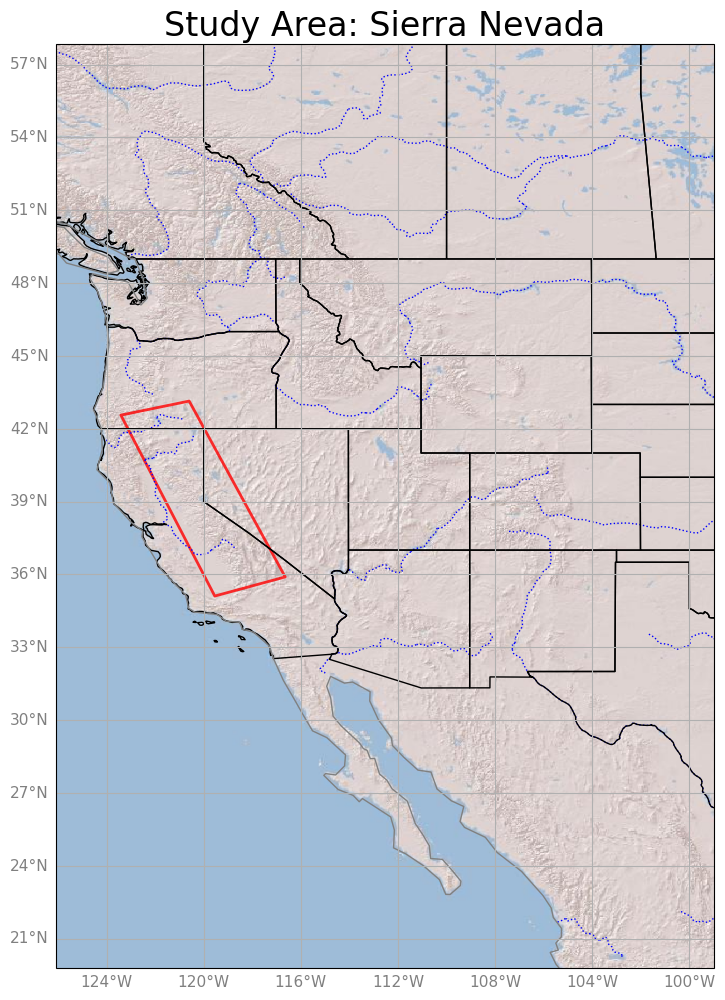

In [10]:
# Plot study area map with the box 

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (18,12), subplot_kw={'projection': ccrs.PlateCarree()})

imextent = gp.read_file("../shape/cvws.shp").set_crs("EPSG:4326").to_crs(4326).buffer(15).total_bounds

lllon, lllat = imextent[0], imextent[1]
urlon, urlat = imextent[2], imextent[3]

# Create a Stamen Terrain instance.
stamen_terrain = cimgt.GoogleTiles(style='terrain', url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

# Create a GeoAxes in the tile's projection.
gl = ax.gridlines(draw_labels=True)
gl.top_labels= False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,91))
gl.ylocator = mticker.FixedLocator(np.linspace(0,90,31))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'gray'}
gl.ylabel_style = {'size': 11, 'color': 'gray'}

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon+12, urlon+4, lllat, urlat])

# Add the Stamen data at zoom level 8.
ax.add_image(stamen_terrain, 5)
# Add study area shape
ax.add_geometries([gmtry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', alpha=0.8, linewidth = 2)

rivers = cartopy.feature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', \
    scale='50m', edgecolor='b', facecolor='none')
ax.add_feature(rivers, facecolor='None', edgecolor='blue', linestyle=':')
ax.add_feature(cfeature.STATES, linewidth=1)
ax.coastlines(resolution='110m', color='gray', linestyle='-', alpha=1)

plt.title("Study Area: Sierra Nevada", size = 24)
plt.show()